# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet.

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

## Video captions

The ActivityNetCaptions dataset https://cs.stanford.edu/people/ranjaykrishna/densevid/ dataset provides a textual description of each videos. Index the video captions on a text field of your OpenSearch index.

##2.1

In [1]:
import json

# Abrir o ficheiro JSON
# O código abre o ficheiro 'train.json' para ler os dados no formato JSON e os carrega na variável 'data'
with open('/content/drive/MyDrive/captions/train.json', 'r') as json_data:
    data = json.load(json_data)

# Lista onde serão armazenados os momentos dos vídeos
video_moments = []

# Itera sobre os dados do JSON
# Para cada item em 'data', o código obtém o 'video_id' e 'info'.
# 'timestamps' são os momentos no vídeo e 'sentences' são as descrições dos momentos.
for video_id, info in data.items():
    timestamps = info.get("timestamps", [])  # Lista de timestamps (momento) do vídeo
    sentences = info.get("sentences", [])  # Lista de frases (descrição dos momentos) do vídeo

    # Calcula o número de momentos (quantidade de timestamps)
    num_momentos = len(timestamps)
    activities = sentences  # Atividades são as descrições dos momentos

    # Adiciona à lista 'video_moments' uma tupla com o ID do vídeo, o número de momentos e as atividades
    video_moments.append((video_id, num_momentos, activities))

# Ordena a lista de vídeos de forma decrescente com base no número de momentos
# O 'key=lambda x: x[1]' indica que a ordenação será feita com base no segundo valor de cada tupla (número de momentos)
video_moments.sort(key=lambda x: x[1], reverse=True)

# Seleciona os 10 vídeos com maior número de momentos
top_10_videos = video_moments[:10]

# Imprime os resultados, mostrando o top 10 vídeos com mais momentos
print("Top 10 vídeos com mais momentos (semantic video segments):\n")

# Para cada vídeo no top 10, imprime o ID do vídeo, o número de momentos e as descrições dos momentos
for video_id, num_momentos, activities in top_10_videos:
    print(f"Vídeo ID: {video_id}")  # Exibe o ID do vídeo
    print(f"   - Número de momentos: {num_momentos}")  # Exibe o número de momentos no vídeo
    print("   - Descrições dos momentos:")  # Inicia a exibição das descrições dos momentos
    for i, activity in enumerate(activities, 1):  # Para cada descrição, imprime o índice e a atividade
        print(f"      {i}. {activity.strip()}")  # Exibe a descrição da atividade, removendo espaços extras
    print()  # Adiciona uma linha em branco entre cada vídeo


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/captions/train.json'

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

##2.2

In [ ]:
import pprint as pp  # Importa o módulo 'pprint' (pretty print) para exibir informações de forma legível
import requests  # Importa a biblioteca 'requests' para fazer requisições HTTP

# Definindo as configurações para se conectar à API
host = 'api.novasearch.org'  # O endereço do servidor de API
port = 443  # A porta usada para a conexão (443 é a porta padrão para HTTPS)

# Credenciais de autenticação
user = 'user06'  # O nome de usuário para autenticação na API
password = 'quarta+mpdw'  # A senha correspondente ao nome de usuário

# Nome do índice a ser utilizado, que é o mesmo que o nome de usuário
index_name = user  # Define o nome do índice como o nome de usuário


In [ ]:
!pip install opensearch-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.5/353.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pprint as pp  # Importa o módulo 'pprint' (pretty print) para exibir informações de forma legível
from opensearchpy import OpenSearch  # Importa o cliente OpenSearch, que é usado para interagir com o OpenSearch
from opensearchpy import helpers  # Importa os helpers do OpenSearch, que fornecem funções auxiliares para facilitar operações

# Cria o cliente do OpenSearch com SSL/TLS ativado, mas desativa a verificação do hostname.
client = OpenSearch(
    hosts = [{'host': host, 'port': port}],  # Especifica o host e a porta para conectar ao servidor OpenSearch
    http_compress = True,  # Habilita a compressão das requisições HTTP
    http_auth = (user, password),  # Define as credenciais de autenticação (usuário e senha)
    use_ssl = True,  # Habilita o uso de SSL para a comunicação segura
    url_prefix = 'opensearch_v2',  # Define um prefixo de URL para a conexão
    verify_certs = False,  # Desativa a verificação do certificado SSL (isso pode ser útil em ambientes de desenvolvimento)
    ssl_assert_hostname = False,  # Desativa a verificação do nome do host no certificado SSL
    ssl_show_warn = False  # Desativa os avisos relacionados ao SSL
)

# Verifica se o índice especificado existe
if client.indices.exists(index_name):

    # Abre o índice se ele existir
    resp = client.indices.open(index = index_name)
    print(resp)  # Exibe a resposta ao abrir o índice

    # Exibe as configurações do índice
    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index = index_name)  # Obtém as configurações do índice
    pp.pprint(settings)  # Exibe as configurações de forma legível

    # Exibe o mapeamento do índice
    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index = index_name)  # Obtém o mapeamento do índice
    pp.pprint(mappings)  # Exibe o mapeamento de forma legível

    # Exibe o número de documentos no índice
    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index = index_name))  # Exibe o número total de documentos no índice
else:
    print("Index does not exist.")  # Caso o índice não exista, exibe uma mensagem


{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'user06': {'settings': {'index': {'creation_date': '1744529062467',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '1',
                                   'provided_name': 'user06',
                                   'refresh_interval': '1s',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'UrmSHpshSCS2NbHDvYwzzg',
                                   'version': {'created': '136387927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'user06': {'mappings': {'dynamic': 'strict',
                         'properties': {'description': {'analyzer': 'standard',
                                          

In [ ]:
if client.indices.exists(index=index_name):
    # Deleta o índice caso ele exista.
    response = client.indices.delete(
        index = index_name  # Especifica o nome do índice a ser deletado
    )
    print('\nDeleting index:')  # Exibe uma mensagem indicando que o índice está sendo deletado
    print(response)  # Exibe a resposta do OpenSearch sobre o processo de deleção



Deleting index:
{'acknowledged': True}


In [ ]:
index_body = {
    "settings": {
        "index": {
            "number_of_shards": 1,  # Define o número de shards para o índice
            "number_of_replicas": 0,  # Define o número de réplicas para o índice
            "refresh_interval": "1s",  # Define o intervalo de atualização para 1 segundo
            "knn": "true"  # Habilita a funcionalidade de KNN (k-nearest neighbors) no índice
        }
    },
    "mappings": {
        "dynamic": "strict",  # Configura o índice para não permitir novos campos dinâmicos (apenas campos definidos)
        "properties": {
            "title": {
                "type": "text",  # O campo 'title' é do tipo texto
                "analyzer": "standard",  # O campo 'title' usa o analisador padrão
                "similarity": "BM25"  # Define o método de similaridade BM25 para o campo 'title'
            },
            "description": {
                "type": "text",  # O campo 'description' é do tipo texto
                "analyzer": "standard",  # O campo 'description' usa o analisador padrão
                "similarity": "BM25"  # Define o método de similaridade BM25 para o campo 'description'
            }
        }
    }
}

if client.indices.exists(index=index_name):  # Verifica se o índice já existe
    print("Index already existed. Nothing to be done.")  # Caso o índice já exista, exibe a mensagem
else:
    response = client.indices.create(index_name, body=index_body)  # Cria o índice com as configurações definidas em 'index_body'
    print('\nCreating index:')  # Exibe uma mensagem indicando que o índice está sendo criado
    print(response)  # Exibe a resposta do OpenSearch sobre o processo de criação do índice



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user06'}


In [ ]:
mappings = client.indices.get_mapping(index=index_name)  # Obtém o mapeamento do índice especificado pelo nome (index_name)
pp.pprint(mappings)  # Exibe o mapeamento do índice de forma mais legível usando pprint (pretty-print)


{'user06': {'mappings': {'dynamic': 'strict',
                         'properties': {'description': {'analyzer': 'standard',
                                                        'similarity': 'BM25',
                                                        'type': 'text'},
                                        'title': {'analyzer': 'standard',
                                                  'similarity': 'BM25',
                                                  'type': 'text'}}}}}


In [ ]:
index_settings = {  # Define as configurações do índice
    "settings": {
        "index": {
            "refresh_interval": "1s"  # Define o intervalo de atualização do índice para 1 segundo
        }
    }
}

client.indices.put_settings(index=index_name, body=index_settings)  # Atualiza as configurações do índice com as novas definições


{'acknowledged': True}

In [ ]:
settings = client.indices.get_settings(index=index_name)  # Obtém as configurações do índice especificado
pp.pprint(settings)  # Exibe as configurações do índice de forma formatada para facilitar a leitura


{'user06': {'settings': {'index': {'creation_date': '1744542761061',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '1',
                                   'provided_name': 'user06',
                                   'refresh_interval': '1s',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'QDqneKbRSROxFPOfUZMQsQ',
                                   'version': {'created': '136387927'}}}}}


In [ ]:
for video_id, num_momentos, sentences in top_10_videos:  # Itera sobre os 10 vídeos com mais momentos
    description = " ".join(sentences)  # Junta todas as sentenças relacionadas ao vídeo em uma única string

    doc = {
        "title": video_id,  # Define o título do documento como o ID do vídeo
        "description": description  # Define a descrição do documento como a string formada pelas sentenças
    }

    response = client.index(index=index_name, id=video_id, body=doc)  # Cria um novo documento no índice do OpenSearch com o título e a descrição
    print(response['result'])  # Exibe o resultado da operação, como "created" ou "updated"


created
created
created
created
created
created
created
created
created
created


In [ ]:
query = {
    "query": {
        "match": {
            "description": "dancing"  # Procurar por vídeos cuja descrição contenha a palavra "dancing"
        }
    }
}

response = client.search(index=index_name, body=query)  # Realiza a busca no índice especificado com a query definida
print("Search Results:")  # Imprime o título "Search Results:" antes dos resultados

for hit in response['hits']['hits']:  # Itera sobre os resultados encontrados na busca
    print(f"Video ID: {hit['_id']} - Title: {hit['_source']['title']}")  # Exibe o ID e o título de cada vídeo retornado pela busca


Search Results:
Video ID: v_3l7quTy4c2s - Title: v_3l7quTy4c2s


In [ ]:
qtxt = "How many people live in London?"  # Define a pergunta de busca (query) sobre o número de pessoas em Londres.

query_bm25 = {
  'size': 5,  # Limita o número de resultados retornados para 5.
  '_source': ['title'],  # Especifica que apenas o campo 'title' será retornado nos resultados.
  'query': {
    'multi_match': {  # Define um tipo de busca que pesquisa em múltiplos campos.
      'query': qtxt,  # O texto da consulta (pergunta) a ser buscado, que é "How many people live in London?".
      'fields': ['description']  # O campo em que a busca será realizada, que é 'description' dos documentos indexados.
    }
  }
}

response = client.search(
    body=query_bm25,  # Passa o corpo da query para o método de busca.
    index=index_name  # Especifica o índice onde a pesquisa será realizada.
)

print('\nSearch results:')  # Imprime o título "Search results:" antes dos resultados.
pp.pprint(response)  # Exibe de forma mais legível o resultado da pesquisa.



Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'v_NiaE7amNW7s',
                    '_index': 'user06',
                    '_score': 2.6867661,
                    '_source': {'title': 'v_NiaE7amNW7s'}},
                   {'_id': 'v_G7kqlq8WhRo',
                    '_index': 'user06',
                    '_score': 1.93245,
                    '_source': {'title': 'v_G7kqlq8WhRo'}},
                   {'_id': 'v_-fjUWhSM6Hc',
                    '_index': 'user06',
                    '_score': 1.1898389,
                    '_source': {'title': 'v_-fjUWhSM6Hc'}},
                   {'_id': 'v_3l7quTy4c2s',
                    '_index': 'user06',
                    '_score': 0.11535299,
                    '_source': {'title': 'v_3l7quTy4c2s'}},
                   {'_id': 'v_tuhHQ-lHIs4',
                    '_index': 'user06',
                    '_score': 0.114883535,
                    '_source': {'title': 'v_tuh

In [ ]:
query_bm25 = {
  'size': 5,  # Limita o número de resultados retornados para 5.
  '_source': ['title'],  # Especifica que apenas o campo 'title' será retornado nos resultados.
  'query': {
        "term": {  # Define um tipo de consulta "term", que busca por uma correspondência exata.
            "description" : 'red'  # A consulta busca por documentos que tenham exatamente o termo "red" no campo 'description'.
        }
   }
}

response = client.search(
    body=query_bm25,  # Passa o corpo da query para o método de busca.
    index=index_name  # Especifica o índice onde a pesquisa será realizada.
)

print('\nSearch results:')  # Imprime o título "Search results:" antes dos resultados.
pp.pprint(response)  # Exibe de forma mais legível o resultado da pesquisa.



Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'v_NiaE7amNW7s',
                    '_index': 'user06',
                    '_score': 1.6896408,
                    '_source': {'title': 'v_NiaE7amNW7s'}},
                   {'_id': 'v_3l7quTy4c2s',
                    '_index': 'user06',
                    '_score': 1.6374952,
                    '_source': {'title': 'v_3l7quTy4c2s'}}],
          'max_score': 1.6896408,
          'total': {'relation': 'eq', 'value': 2}},
 'timed_out': False,
 'took': 1}


In [ ]:
qtxt = "How many people live in London?"  # Define o texto de consulta que será usado para a pesquisa.

query_bm25 = {
  'size': 5,  # Limita o número de resultados retornados para 5.
  '_source': ['contents'],  # Especifica que apenas o campo 'contents' será retornado nos resultados.
  'query': {
      'bool': {  # A consulta usa o tipo "bool", que permite combinar várias condições.
          "must": {  # A parte "must" exige que o termo fornecido seja encontrado.
            "term": {  # A consulta de tipo "term" exige uma correspondência exata do termo 'red' no campo 'description'.
                "description": 'red'
            }
          },
          "should": {  # A parte "should" indica que o termo fornecido não é obrigatório, mas aumentará a pontuação do documento se encontrado.
            'multi_match': {  # A consulta "multi_match" permite procurar o texto fornecido em vários campos.
              'query': qtxt,  # O texto a ser pesquisado é a pergunta "How many people live in London?".
              'fields': ['description']  # A consulta será executada no campo 'description'.
            }
          }
      }
  }
}

response = client.search(  # Executa a pesquisa com a consulta configurada.
    body=query_bm25,  # Passa o corpo da query para a pesquisa.
    index=index_name  # Especifica o índice onde a pesquisa será realizada.
)

print('\nSearch results:')  # Exibe a frase "Search results:" antes dos resultados.
pp.pprint(response)  # Exibe os resultados da pesquisa de forma legível.



Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'v_NiaE7amNW7s',
                    '_index': 'user06',
                    '_score': 4.4831715,
                    '_source': {}},
                   {'_id': 'v_3l7quTy4c2s',
                    '_index': 'user06',
                    '_score': 1.5379808,
                    '_source': {}},
                   {'_id': 'v_Ke5MPiv-wrY',
                    '_index': 'user06',
                    '_score': 1.2419238,
                    '_source': {}}],
          'max_score': 4.4831715,
          'total': {'relation': 'eq', 'value': 3}},
 'timed_out': False,
 'took': 2}


In [ ]:
if client.indices.exists(index=index_name):  # Verifica se o índice com o nome especificado já existe.
    # Delete the index.  # Se o índice existir, o código irá apagá-lo.
    response = client.indices.delete(
        index=index_name  # Chama a função 'delete' para excluir o índice com o nome 'index_name'.
    )
    print('\nDeleting index:')  # Exibe a mensagem "Deleting index:" indicando que o índice está a ser apagado.
    print(response)  # Exibe a resposta da operação de exclusão (informações sobre o sucesso ou erro).



Deleting index:
{'acknowledged': True}


In [ ]:
index_body = {  # Define a estrutura (body) do índice a ser criado no OpenSearch.
    "settings": {  # Configurações do índice.
        "index": {
            "number_of_shards": 1,  # Número de shards (partições do índice). Aqui, o índice terá 1 shard.
            "number_of_replicas": 0,  # Número de réplicas ( cópias de segurança do índice). Aqui, não será criada réplica.
            "refresh_interval": "1s",  # Intervalo de atualização do índice (tempo entre cada refresh do índice).
            "knn": "true"  # Habilita a busca aproximada por vizinhos mais próximos (KNN), útil para vetores e embeddings.
        }
    },
    "mappings": {  # Define os mapeamentos de propriedades e tipos de dados no índice.
        "dynamic": "strict",  # Impede a criação de campos dinâmicos no índice. Apenas campos especificados serão permitidos.
        "properties": {  # Define os campos e seus tipos no índice.
            "title": {  # Campo 'title' do índice.
                "type": "text",  # Tipo de dado 'text', para armazenar texto.
                "analyzer": "standard",  # Usará o analisador padrão para o texto.
                "similarity": "BM25"  # Usará o algoritmo BM25 para calcular a relevância nas buscas.
            },
            "description": {  # Campo 'description' do índice.
                "type": "text",  # Tipo de dado 'text', para armazenar texto.
                "analyzer": "standard",  # Usará o analisador padrão para o texto.
                "similarity": "BM25"  # Usará o algoritmo BM25 para calcular a relevância nas buscas.
            },
            "sentence_embedding": {  # Campo para armazenar embeddings de sentenças como vetores.
                "type": "knn_vector",  # Define que o campo será um vetor KNN (k-nearest neighbors) para realizar buscas aproximadas.
                "dimension": 768,  # Define a dimensão do vetor (neste caso, 768, comum para embeddings como BERT).
                "method": {  # Configura o método de pesquisa KNN.
                    "name": "hnsw",  # O algoritmo utilizado é HNSW (Hierarchical Navigable Small World), eficiente para buscas aproximadas.
                    "space_type": "innerproduct",  # Tipo de espaço de métrica usado no cálculo de distância (produto interno).
                    "engine": "faiss",  # Usando o motor FAISS para realizar a busca de vetores de alta performance.
                    "parameters": {  # Parâmetros do método HNSW.
                        "ef_construction": 256,  # Controle de qualidade do grafo (quanto maior, melhor a precisão, porém mais lento).
                        "m": 48  # Número de conexões por nó no grafo (afeta desempenho e precisão).
                    }
                }
            }
        }
    }
}

if client.indices.exists(index=index_name):  # Verifica se o índice já existe.
    print("Index already existed. Nothing to be done.")  # Caso o índice já exista, imprime uma mensagem informando que nada precisa ser feito.
else:
    response = client.indices.create(index_name, body=index_body)  # Caso o índice não exista, cria um novo índice com a estrutura definida.
    print('\nCreating index:')  # Exibe uma mensagem indicando que o índice está a ser criado.
    print(response)  # Exibe a resposta da operação de criação do índice.



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user06'}


In [ ]:
mappings = client.indices.get_mapping(index=index_name)  # Solicita o mapeamento do índice especificado (index_name).
pp.pprint(mappings)  # Exibe o mapeamento obtido de forma formatada e legível.


{'user06': {'mappings': {'dynamic': 'strict',
                         'properties': {'description': {'analyzer': 'standard',
                                                        'similarity': 'BM25',
                                                        'type': 'text'},
                                        'sentence_embedding': {'dimension': 768,
                                                               'method': {'engine': 'faiss',
                                                                          'name': 'hnsw',
                                                                          'parameters': {'ef_construction': 256,
                                                                                         'm': 48},
                                                                          'space_type': 'innerproduct'},
                                                               'type': 'knn_vector'},
                                        'title': {'analy

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [ ]:
# Para cada vídeo nos top 10, obtemos o ID do vídeo, o número de momentos e as sentenças associadas.
for video_id, num_momentos, sentences in top_10_videos:
    # As sentenças são unidas em uma única string, que serve como a descrição do vídeo.
    description = " ".join(sentences)

    # Criamos um dicionário com os dados que serão indexados no OpenSearch.
    doc = {
        # O título do documento será o ID do vídeo.
        "title": video_id,

        # A descrição será a string concatenada das sentenças.
        "description": description,

        # O embedding (vetor semântico) da descrição é calculado usando a função encode.
        # O resultado é convertido de tensor para lista com .tolist().
        "sentence_embedding": encode(description).squeeze().tolist()
    }

    # O documento é indexado no OpenSearch, usando o ID do vídeo e o conteúdo do dicionário doc.
    response = client.index(index=index_name, id=video_id, body=doc)

    # A resposta do processo de indexação é impressa para mostrar o resultado da operação.
    print(response['result'])


created
created
created
created
created
created
created
created
created
created


In [ ]:
# Lista de diferentes queries para testar o comportamento com diferentes valores de k
queries = [
    "How many people live in London?",  # Exemplo de query sobre a população em Londres
    "A woman is dancing.",             # Exemplo de query sobre uma mulher dançando
    "Someone is doing sit-ups on the floor.",  # Exemplo de query sobre uma pessoa fazendo abdominais
    "This is a title screen."          # Exemplo de query sobre uma tela de título
]

# Iterar sobre todas as queries na lista
for query in queries:
    print(f"\nQuery: {query}")  # Imprime a query atual

    # Codifica a query em um vetor de embeddings utilizando a função 'encode'.
    query_emb = encode(query).squeeze(0).tolist()

    # Teste com k = 1
    query_denc_k1 = {
        'size': 5,  # Retorna 5 resultados
        '_source': ['title'],  # Apenas o título será retornado
        "query": {
            "knn": {  # Pesquisa utilizando k-NN (k-nearest neighbors)
                "sentence_embedding": {
                    "vector": query_emb,  # Vetor da query
                    "k": 1  # Valor de k = 1 (1 vizinho mais próximo)
                }
            }
        }
    }

    # Realiza a busca com k = 1
    response_k1 = client.search(
        body=query_denc_k1,
        index=index_name
    )

    print("Results for k = 1:")  # Imprime os resultados para k = 1
    # Exibe os títulos dos vídeos e seus scores
    for hit in response_k1['hits']['hits']:
        print(f"Title: {hit['_source']['title']} | Score: {hit['_score']}")

    # Teste com k = 3, copiando a query de k = 1 e alterando o valor de k
    query_denc_k3 = query_denc_k1.copy()
    query_denc_k3["query"]["knn"]["sentence_embedding"]["k"] = 3  # Atualiza k para 3

    # Realiza a busca com k = 3
    response_k3 = client.search(
        body=query_denc_k3,
        index=index_name
    )

    print("Results for k = 3:")  # Imprime os resultados para k = 3
    # Exibe os títulos dos vídeos e seus scores
    for hit in response_k3['hits']['hits']:
        print(f"Title: {hit['_source']['title']} | Score: {hit['_score']}")

    # Teste com k = 5, copiando a query de k = 1 e alterando o valor de k
    query_denc_k5 = query_denc_k1.copy()
    query_denc_k5["query"]["knn"]["sentence_embedding"]["k"] = 5  # Atualiza k para 5

    # Realiza a busca com k = 5
    response_k5 = client.search(
        body=query_denc_k5,
        index=index_name
    )

    print("Results for k = 5:")  # Imprime os resultados para k = 5
    # Exibe os títulos dos vídeos e seus scores
    for hit in response_k5['hits']['hits']:
        print(f"Title: {hit['_source']['title']} | Score: {hit['_score']}")



Query: How many people live in London?
Results for k = 1:
Title: v_RJpWgi0EaUE | Score: 1.123466
Title: v_v7o9uSu9AVI | Score: 1.0703411
Title: v_-fjUWhSM6Hc | Score: 1.0491134
Title: v_tuhHQ-lHIs4 | Score: 1.0471044
Title: v_G7kqlq8WhRo | Score: 1.0458224
Results for k = 3:
Title: v_RJpWgi0EaUE | Score: 1.123466
Title: v_v7o9uSu9AVI | Score: 1.0703411
Title: v_-fjUWhSM6Hc | Score: 1.0491134
Title: v_tuhHQ-lHIs4 | Score: 1.0471044
Title: v_G7kqlq8WhRo | Score: 1.0458224
Results for k = 5:
Title: v_RJpWgi0EaUE | Score: 1.123466
Title: v_v7o9uSu9AVI | Score: 1.0703411
Title: v_-fjUWhSM6Hc | Score: 1.0491134
Title: v_tuhHQ-lHIs4 | Score: 1.0471044
Title: v_G7kqlq8WhRo | Score: 1.0458224

Query: A woman is dancing.
Results for k = 1:
Title: v_RJpWgi0EaUE | Score: 1.451176
Title: v_NiaE7amNW7s | Score: 1.392946
Title: v_3l7quTy4c2s | Score: 1.3524444
Title: v_tuhHQ-lHIs4 | Score: 1.2828703
Title: v_Ke5MPiv-wrY | Score: 1.2728064
Results for k = 3:
Title: v_RJpWgi0EaUE | Score: 1.451176
Tit

In [ ]:
# Verifica se o índice já existe
if client.indices.exists(index=index_name):
    # Caso o índice exista, ele será deletado.
    response = client.indices.delete(
        index = index_name  # Deleta o índice com o nome 'index_name'
    )
    print('\nDeleting index:')  # Imprime que o índice está sendo deletado
    print(response)  # Exibe a resposta da operação de deleção



Deleting index:
{'acknowledged': True}


In [ ]:
# Definindo o corpo do índice para criação com configurações e mapeamentos
index_body = {
    "settings": {  # Configurações do índice
        "index": {
            "number_of_shards": 1,  # Número de shards do índice
            "number_of_replicas": 0,  # Número de réplicas do índice
            "refresh_interval": "1s",  # Intervalo de atualização do índice
            "knn": "true"  # Habilita a pesquisa KNN (Nearest Neighbor)
        }
    },
    "mappings": {  # Definindo mapeamentos para os campos do índice
        "dynamic": "strict",  # Desativa a criação automática de campos não definidos
        "properties": {
            "title": {  # Campo título
                "type": "text",  # Tipo de dado (texto)
                "analyzer": "standard",  # Analisador padrão para texto
                "similarity": "BM25"  # Usando a métrica de similaridade BM25
            },
            "description": {  # Campo descrição
                "type": "text",  # Tipo de dado (texto)
                "analyzer": "standard",  # Analisador padrão para texto
                "similarity": "BM25"  # Usando a métrica de similaridade BM25
            },
            "duration": {  # Campo duração
                "type": "float"  # Tipo de dado (flutuante)
            },
            "num_moments": {  # Campo número de momentos
                "type": "integer"  # Tipo de dado (inteiro)
            },
            "sentence_embedding": {  # Campo de embeddings de frases
                "type": "knn_vector",  # Tipo de dado KNN (vetores de embeddings)
                "dimension": 768,  # Dimensão do vetor (768 para BERT-like embeddings)
                "method": {
                    "name": "hnsw",  # Método de índice HNSW (Hierarchical Navigable Small World)
                    "space_type": "innerproduct",  # Tipo de espaço (produto interno)
                    "engine": "faiss",  # Motor FAISS para indexação eficiente de vetores
                    "parameters": {
                        "ef_construction": 256,  # Controlo de qualidade do grafo (maior valor, maior precisão)
                        "m": 48  # Número de ligações por nó no grafo (afeta desempenho e precisão)
                    }
                }
            }
        }
    }
}

# Verificando se o índice já existe
if client.indices.exists(index=index_name):
    print("Index already existed. Nothing to be done.")  # Se o índice já existir, nenhuma ação é feita
else:
    # Caso o índice não exista, cria-se o índice com a configuração definida
    response = client.indices.create(index=index_name, body=index_body)
    print('\nCreating index:')  # Imprime que o índice está sendo criado
    print(response)  # Exibe a resposta da operação de criação



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user06'}


In [ ]:
import json

# Abrir o ficheiro JSON e carregar os dados.
with open('/content/drive/MyDrive/captions/train.json', 'r') as json_data:
    data = json.load(json_data)

# Lista para armazenar os momentos dos vídeos.
video_moments = []

# Itera sobre os dados dos vídeos.
for video_id, info in data.items():
    timestamps = info.get("timestamps", [])  # Obtém os timestamps dos momentos.
    sentences = info.get("sentences", [])  # Obtém as descrições das atividades.
    duration = info.get("duration", 0.0)  # Obtém a duração do vídeo.

    num_momentos = len(timestamps)  # Conta o número de momentos (timestamps).
    activities = sentences  # Atribui as descrições das atividades.

    # Adiciona os dados do vídeo à lista.
    video_moments.append((video_id, num_momentos, duration, activities))

# Ordena a lista de vídeos pelos momentos, em ordem decrescente.
video_moments.sort(key=lambda x: x[1], reverse=True)

# Seleciona os top 10 vídeos com mais momentos.
top_10_videos = video_moments[:10]

# Exibe as informações sobre os 10 vídeos com mais momentos.
print("Top 10 vídeos com mais momentos (semantic video segments):\n")
for video_id, num_momentos, duration, activities in top_10_videos:
    print(f"Vídeo ID: {video_id}")  # Exibe o ID do vídeo.
    print(f"   - Número de momentos: {num_momentos}")  # Exibe o número de momentos.
    print(f"   - Duração: {duration:.2f} segundos")  # Exibe a duração do vídeo, formatada com 2 casas decimais.
    print("   - Descrições dos momentos:")
    # Exibe as descrições das atividades, numeradas.
    for i, activity in enumerate(activities, 1):
        print(f"      {i}. {activity.strip()}")


Top 10 vídeos com mais momentos (semantic video segments):

Vídeo ID: v_3l7quTy4c2s
   - Número de momentos: 27
   - Duração: 174.29 segundos
   - Descrições dos momentos:
      1. A cheerleader girl stands in the grass.
      2. A young man wearing baseball hat greats her with a pie tin and jokes with her.
      3. The man pushes a pie tin in the girls face as a joke getting her very messy.
      4. A girl in gymnastics class does tumbling down a red mat with team looking on.
      5. A woman cheerleader boxes with a mascot during a football game.
      6. The mascot engulfs the girl and pulls her into his uniform.
      7. A cheer leading group comes together in a circle holding hands and flip team members when one falls to the ground.
      8. A group of cheerleaders in black to back flips on a track of football field.
      9. A group of girls hoist up[ a teammate to do a human pyramid.
      10. The teammate falls to the ground and lands on top of others.
      11. A man in Hawaii

In [ ]:
# Para cada vídeo nos 10 principais vídeos, formata os dados e indexa-os no OpenSearch.
for video_id, num_momentos, duration, activities in top_10_videos:
    # Junta todas as descrições das atividades em uma única string (descrição do vídeo).
    description = " ".join(activities)

    # Cria o documento com os dados que serão indexados.
    doc = {
        "title": video_id,  # O ID do vídeo.
        "duration" : duration,  # A duração do vídeo.
        "description": description,  # A descrição concatenada das atividades.
        "sentence_embedding": encode(description).squeeze().tolist()  # O embedding das sentenças do vídeo.
    }

    # Indexa o documento no OpenSearch, usando o ID do vídeo como o identificador único.
    response = client.index(index=index_name, id=video_id, body=doc)

    # Exibe o resultado da indexação (por exemplo, se o documento foi criado ou atualizado).
    print(response['result'])


created
created
created
created
created
created
created
created
created
created


In [ ]:
# Define o vetor de consulta (embedding) da frase "A woman is dancing in a room"
query_vector = encode("A woman is dancing in a room").squeeze(0).tolist()

# Configura a consulta para buscar vídeos no OpenSearch com base no vetor de similaridade e filtros adicionais.
query = {
  "size": 5,  # Limita os resultados a 5 vídeos.
  "_source": ["title", "duration", "number_of_moments"],  # Especifica os campos que queremos retornar.
  "query": {
    "bool": {
      "must": {
        "knn": {
          "sentence_embedding": {  # Realiza a busca usando KNN com o vetor da consulta.
            "vector": query_vector,  # O vetor de consulta.
            "k": 5  # Número de resultados mais semelhantes a retornar.
          }
        }
      },
      "filter": [
        {
          "range": {  # Filtra os vídeos com duração maior ou igual a 60 segundos.
            "duration": { "gte": 60 }
          }
        },
        {
          "range": {  # Filtra os vídeos com número de momentos maior ou igual a 3.
            "number_of_moments": { "gte": 3 }
          }
        }
      ]
    }
  }
}


In [ ]:
# Define a consulta para buscar vídeos que correspondam ao texto "woman dancing in a room" no campo "description"
query_text = {
  "query": {
    "match": {  # Realiza uma busca de correspondência de texto no campo "description".
      "description": "woman dancing in a room"  # Frase para buscar na descrição dos vídeos.
    }
  },
  "_source": ["title", "description"]  # Limita os campos retornados para "title" e "description".
}

# Executa a consulta no índice e armazena a resposta
response = client.search(index=index_name, body=query_text)

# Exibe os resultados da consulta de forma legível
pp.pprint(response)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'v_3l7quTy4c2s',
                    '_index': 'user06',
                    '_score': 3.0809388,
                    '_source': {'description': 'A cheerleader girl stands in '
                                               'the grass.  A young man '
                                               'wearing baseball hat greats '
                                               'her with a pie tin and jokes '
                                               'with her.  The man pushes a '
                                               'pie tin in the girls face as a '
                                               'joke getting her very messy.  '
                                               'A girl in gymnastics class '
                                               'does tumbling down a red mat '
                                               'with team looking on.  A woman '
                   

In [ ]:
# Define a consulta utilizando o vetor de embeddings para o texto "a woman dancing"
query = "a woman dancing"
query_emb = encode(query).squeeze(0).tolist()  # Codifica a consulta em um vetor de embeddings.

# Configura a consulta de k-NN (nearest neighbors) para encontrar os 5 vídeos mais semelhantes com base no embedding da descrição.
query_embed = {
  "size": 5,  # Retorna os 5 resultados mais próximos.
  "_source": ["title", "description"],  # Limita os campos retornados para "title" e "description".
  "query": {
    "knn": {  # Realiza a busca utilizando K-Nearest Neighbors.
      "sentence_embedding": {  # Campo onde está o vetor de embedding dos vídeos.
        "vector": query_emb,  # Vetor de embedding da consulta.
        "k": 5  # Número de vizinhos mais próximos a serem retornados.
      }
    }
  }
}

# Executa a consulta k-NN no índice e armazena a resposta.
response = client.search(index=index_name, body=query_embed)

# Exibe os resultados da consulta de forma legível.
pp.pprint(response)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'v_RJpWgi0EaUE',
                    '_index': 'user06',
                    '_score': 1.4532322,
                    '_source': {'description': 'Three individuals sit on stage '
                                               'and have a conversation.  Two '
                                               'boys dance in the same '
                                               'fashion.   An image of a man '
                                               'is incorporated into the '
                                               'screen with the dancers.  The '
                                               'man cover his face with his '
                                               'hand.  The man and woman '
                                               'gesture the dancers hand '
                                               'movements.  This man gets off '
                             

In [ ]:
# Define a consulta utilizando filtros para restringir os resultados com base em duração e número de momentos.
query_filters = {
  "query": {
    "bool": {
      "filter": [  # Aplica filtros na consulta.
        {"range": {"duration": {"lte": 70}}},  # Filtra vídeos com duração menor ou igual a 70 segundos.
        {"range": {"num_moments": {"gte": 3}}}  # Filtra vídeos com pelo menos 3 momentos.
      ]
    }
  },
  "_source": ["title", "duration", "num_moments"]  # Limita os campos retornados para "title", "duration" e "num_moments".
}

# Executa a consulta no índice e armazena a resposta.
response = client.search(index=index_name, body=query_filters)

# Exibe os resultados da consulta de forma legível.
pp.pprint(response)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [],
          'max_score': None,
          'total': {'relation': 'eq', 'value': 0}},
 'timed_out': False,
 'took': 2}


In [ ]:
# Define a consulta que combina uma busca de k-vizinhos mais próximos (knn) com filtros para duração e número de momentos.
query = "fitness exercise"  # A consulta de texto a ser utilizada para a busca.
query_emb = encode(query).squeeze(0).tolist()  # Codifica a consulta para gerar o vetor de embedding.

# Define a consulta combinada que faz uso de knn e de filtros adicionais para a duração e número de momentos.
query_combined = {
  "size": 5,  # Limita os resultados retornados para 5.
  "_source": ["title", "description", "duration", "num_moments"],  # Limita os campos retornados para "title", "description", "duration", "num_moments".
  "query": {
    "bool": {
      "must": {  # A consulta "must" garante que o k-vizinho mais próximo será usado.
        "knn": {
          "sentence_embedding": {
            "vector": query_emb,  # Usa o vetor de embedding gerado da consulta "fitness exercise".
            "k": 5  # Busca pelos 5 vizinhos mais próximos.
          }
        }
      },
      "filter": [  # Aplica filtros para limitar a duração e o número de momentos.
        {"range": {"duration": {"lte": 80}}},  # Filtra vídeos com duração menor ou igual a 80 segundos.
        {"range": {"num_moments": {"gte": 3}}}  # Filtra vídeos com pelo menos 3 momentos.
      ]
    }
  }
}

# Executa a consulta no índice e armazena a resposta.
response = client.search(index=index_name, body=query_combined)

# Exibe os resultados da consulta de forma legível.
pp.pprint(response)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [],
          'max_score': None,
          'total': {'relation': 'eq', 'value': 0}},
 'timed_out': False,
 'took': 3}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

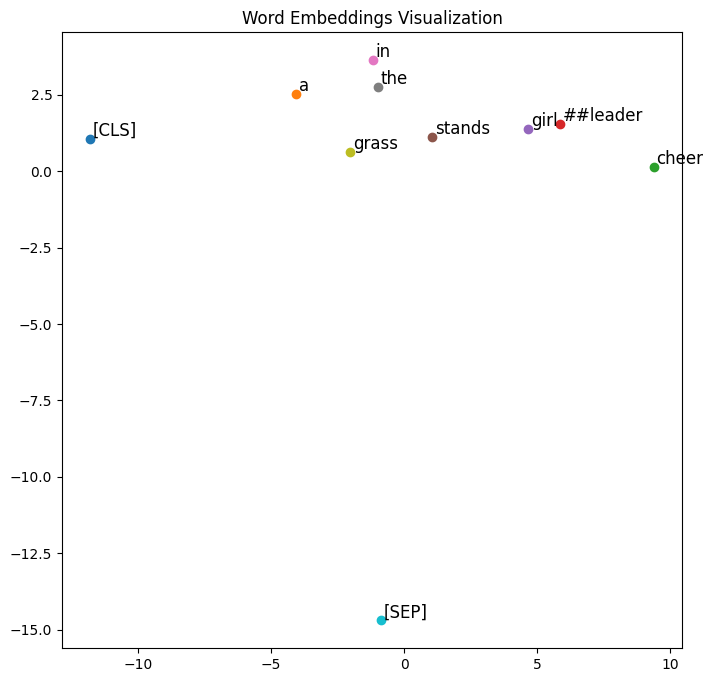

In [1]:
from transformers import BertTokenizer, BertModel  # Importa as bibliotecas do transformers para o BERT.
import torch  # Importa o PyTorch para manipulação de tensores.
from sklearn.decomposition import PCA  # Importa PCA da sklearn para redução de dimensionalidade.
import matplotlib.pyplot as plt  # Importa a matplotlib para visualização.

# Define a sentença a ser processada
sentence = "A cheerleader girl stands in the grass"

# Carrega o tokenizador e o modelo BERT pré-treinado
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # Usa o tokenizador do BERT sem distinção de maiúsculas e minúsculas.
model = BertModel.from_pretrained("bert-base-uncased")  # Usa o modelo BERT pré-treinado base.

# Tokeniza a sentença para transformar em ids de tokens
inputs = tokenizer(sentence, return_tensors="pt")  # Retorna os tensores de entrada para o modelo BERT.
with torch.no_grad():  # Desativa o cálculo de gradientes, pois não estamos treinando o modelo.
    outputs = model(**inputs)  # Passa os dados pelos modelos BERT e obtém as saídas.

# Extrai as representações de embeddings dos tokens
token_embeddings = outputs.last_hidden_state.squeeze(0)  # Obtém as representações de tokens de dimensão (seq_len, hidden_dim).
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))  # Converte os ids dos tokens de volta para palavras.

# Reduz a dimensionalidade dos embeddings para 2D usando PCA
pca = PCA(n_components=2)  # Cria o modelo PCA para redução de dimensionalidade para 2 componentes.
emb_2d = pca.fit_transform(token_embeddings.numpy())  # Aplica o PCA para reduzir os embeddings para 2D.

# Visualização dos embeddings 2D
plt.figure(figsize=(8, 8))  # Cria uma figura para a visualização.
for i, token in enumerate(tokens):  # Para cada token, plota a sua posição 2D.
    x, y = emb_2d[i]  # Obtém as coordenadas 2D.
    plt.scatter(x, y)  # Plota o ponto para o token.
    plt.text(x+0.1, y+0.1, token, fontsize=12)  # Adiciona o texto com o nome do token, um pouco deslocado para evitar sobreposição.
plt.title("Word Embeddings Visualization")  # Define o título do gráfico.
plt.show()  # Exibe o gráfico com os embeddings 2D dos tokens.


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


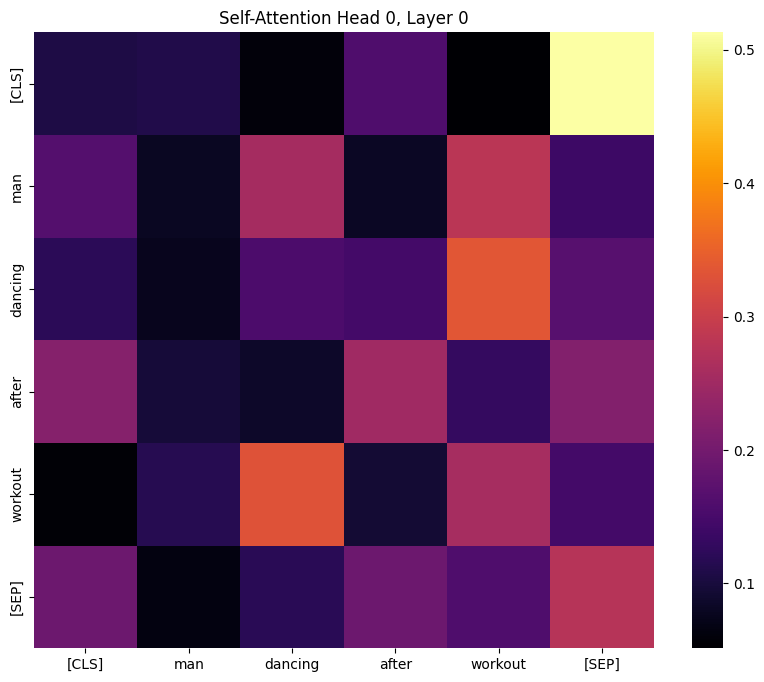

In [ ]:
import seaborn as sns  # Importa a biblioteca Seaborn para a criação de gráficos de calor (heatmap).
import numpy as np  # Importa a biblioteca NumPy para manipulação de arrays numéricos.

# Tokeniza a sentença de entrada
inputs = tokenizer(sentence, return_tensors="pt")  # Tokeniza a sentença e converte-a em tensores para o modelo.

# Passa os dados pelo modelo BERT e ativa a saída das atenções
outputs = model(**inputs, output_attentions=True)  # Obtém a saída do modelo, incluindo as atenções.
attentions = outputs.attentions  # Extrai as atenções das saídas do modelo.

# Escolhe o layer (camada) e a head (cabeça) de atenção para visualização
layer = 0  # Define o primeiro layer para análise.
head = 0  # Define a primeira cabeça de atenção.

# Extrai a matriz de atenção para a camada e cabeça especificadas
attention = attentions[layer][0, head].detach().numpy()  # Detach para remover o tensor da computação de gradiente e converte para NumPy.

# Converte os ids dos tokens de volta para palavras
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))  # Obtém os tokens da sentença.

# Cria o gráfico de calor para visualizar a atenção
plt.figure(figsize=(10, 8))  # Define o tamanho da figura do gráfico.
sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="inferno", annot=False)  # Cria o gráfico de calor usando Seaborn.
plt.title(f"Self-Attention Head {head}, Layer {layer}")  # Define o título do gráfico com o número da cabeça e camada de atenção.
plt.show()  # Exibe o gráfico.
